## Import dataset from google gcp

In [1]:
df = spark.read.csv("gs://mit805_data_bucket/data_raw/final_animedataset.csv", header = True, inferSchema=True)

In [3]:
df.show(5)

+--------+--------+--------+-------+------+-------------+----+------+-----+---------+------+----------+--------------------+
|username|anime_id|my_score|user_id|gender|        title|type|source|score|scored_by|  rank|popularity|               genre|
+--------+--------+--------+-------+------+-------------+----+------+-----+---------+------+----------+--------------------+
|karthiga|      21|       9|2255153|Female|    One Piece|  TV| Manga| 8.54| 423868.0|  91.0|      35.0|Action, Adventure...|
|karthiga|      59|       7|2255153|Female|      Chobits|  TV| Manga| 7.53| 175388.0|1546.0|     188.0|Sci-Fi, Comedy, D...|
|karthiga|      74|       7|2255153|Female| Gakuen Alice|  TV| Manga| 7.77|  33244.0| 941.0|    1291.0|Comedy, School, S...|
|karthiga|     120|       7|2255153|Female|Fruits Basket|  TV| Manga| 7.77| 167968.0| 939.0|     222.0|Slice of Life, Co...|
|karthiga|     178|       7|2255153|Female| Ultra Maniac|  TV| Manga| 7.26|   9663.0|2594.0|    2490.0|Magic, Comedy, Ro...|


In [38]:
# Aggregate data by 'type'
type_counts = df.groupBy("type").count().orderBy("count", ascending=True)
type_counts = type_counts .withColumn("score", type_counts["score"].cast("float"))

# Aggregate data by 'source'
source_counts = df.groupBy("source").count().orderBy("count", ascending=True)

# Convert to Pandas for visualization
type_pdf = type_counts.toPandas()
source_pdf = source_counts.toPandas()


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Plotting
plt.figure(figsize=(6, 9))
type_counts.set_index('type')['count'].plot(kind='barh', color='skyblue')  # Use 'barh' for horizontal bars
plt.title('Distribution by Type')
plt.xlabel('Count')  # Adjusted x and y labels
plt.ylabel('Type')
plt.tight_layout()
plt.savefig("type_distribution_horizontal.png")
plt.show()


In [ ]:
plt.figure(figsize=(6, 12))
source_pdf.set_index('source')['count'].plot(kind='barh', color='lightcoral')
plt.title('Distribution by Source')
plt.ylabel('Count')
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("source_distribution.png")
plt.show()

## Score Distribution by Gender

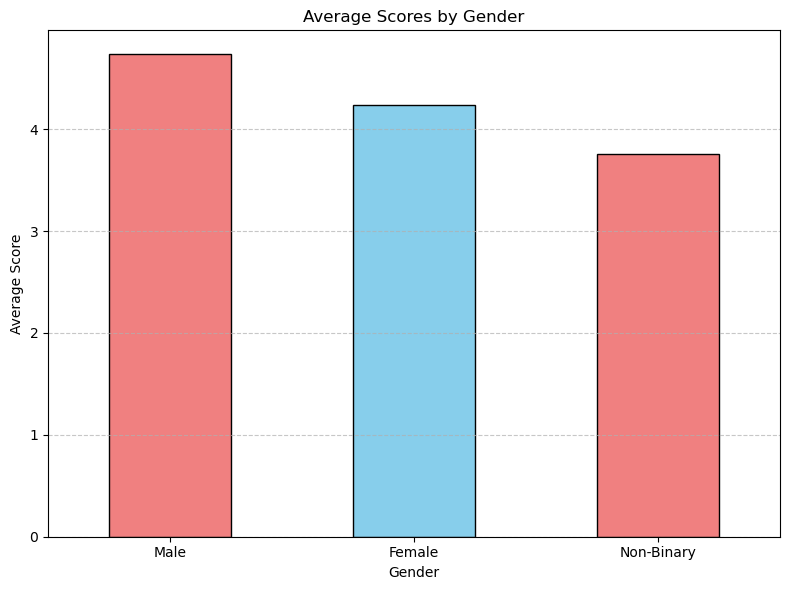

In [11]:
from pyspark.sql import functions as F
# Compute average score by gender
gender_avg_scores = df.groupBy("gender").agg(F.avg("my_score").alias("average_score")).orderBy("average_score", ascending=False)

# Convert to Pandas for visualization
gender_avg_pdf = gender_avg_scores.toPandas()

# Plotting
plt.figure(figsize=(8, 6))
gender_avg_pdf.set_index('gender')['average_score'].plot(kind='bar', color=['lightcoral', 'skyblue'], edgecolor='black')
plt.title('Average Scores by Gender')
plt.ylabel('Average Score')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("gender_avg_score_distribution.png")
plt.show()

## Distrubtion of User Scores

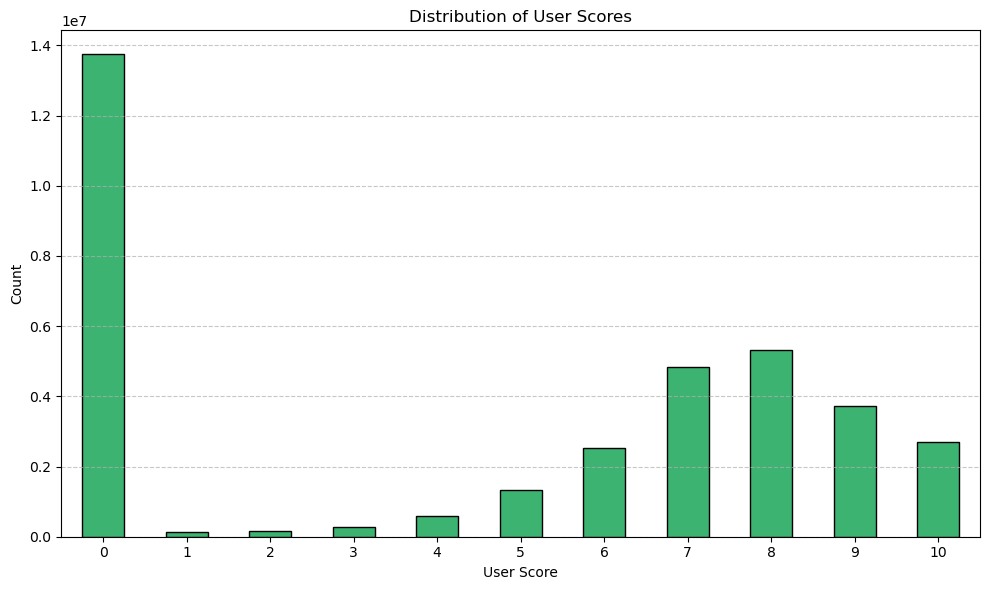

In [12]:
# Compute the distribution of user scores
user_score_distribution = df.groupBy("my_score").count().orderBy("my_score")

# Convert to Pandas for visualization
user_score_pdf = user_score_distribution.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
user_score_pdf.set_index('my_score')['count'].plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Distribution of User Scores')
plt.ylabel('Count')
plt.xlabel('User Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("user_score_distribution.png")
plt.show()


## Average use score for diffenernt formats

## 1. Aggregate the data in PySpark:

In [42]:
from pyspark.sql import functions as F
# Aggregate average score by 'type'
avg_score_by_type = df.groupBy("source").agg(F.avg("my_score").alias("avg_my_score_by_type"))

# Since 'genre' can have multiple values in a single row (comma-separated), we'll first explode the 'genre' column
genres_exploded = df.withColumn("genre", F.explode(F.split("genre", ", ")))
avg_score_by_genre = genres_exploded.groupBy("genre").agg(F.avg("my_score").alias("avg_my_score_by_genre"))

## 2. Convert the aggregated data to pandas DataFrames:

In [43]:
avg_score_by_type_pd = avg_score_by_type.toPandas()
avg_score_by_genre_pd = avg_score_by_genre.toPandas()

## 3. Visualize using seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sorted_avg_score_by_type_pd = avg_score_by_type_pd.sort_values(by='avg_my_score_by_type', ascending=False)

# Visualization for 'type' with horizontal orientation
plt.figure(figsize=(6, 8))
sns.barplot(y='source', x='avg_my_score_by_type', data=sorted_avg_score_by_type_pd, palette='viridis')
plt.title('Average User Score by Anime Source')
plt.xlabel('Average Score')
plt.ylabel('Anime Source')
plt.tight_layout()
plt.savefig('horizontal_average_score_by_type.png')
plt.show()


# Visualization for 'genre'
plt.figure(figsize=(6, 5))
sns.barplot(y='genre', x='avg_my_score_by_genre', data=avg_score_by_genre_pd.sort_values('avg_my_score_by_genre', ascending=False).head(10), palette='viridis')
plt.title('Average User Score by Anime Genre')
plt.xlabel('Average Score')
plt.ylabel('Anime Genre')
plt.tight_layout()
plt.savefig('average_score_by_genre.png')
plt.show()


## User rating vs Overal Popularity

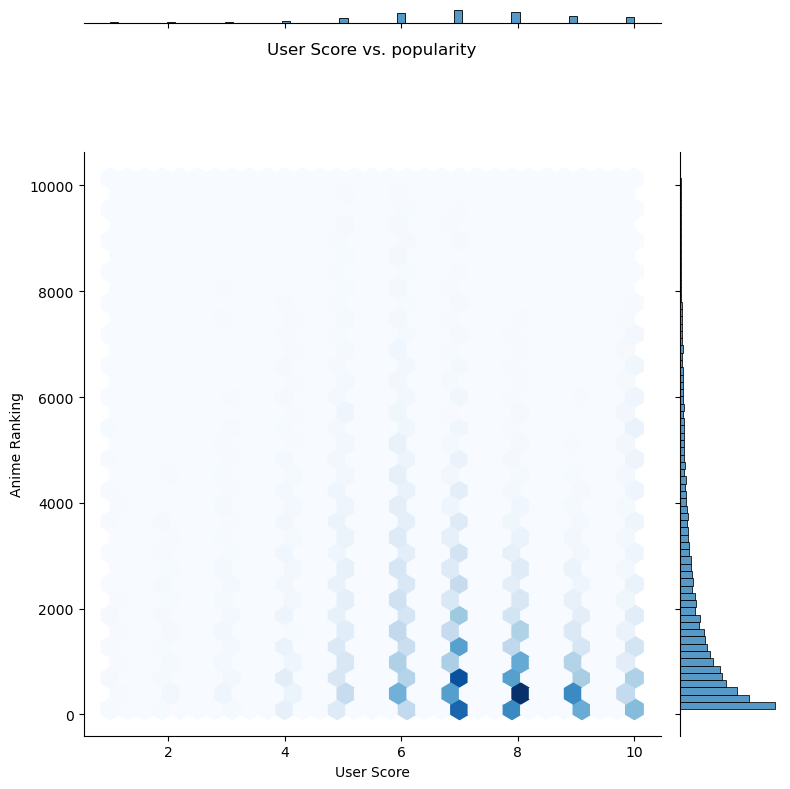

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

small_data = df.limit(40000)  # only take 1000 rows
# Filter out rows where "my_score" is zero and "popularity" is zero
filtered_data = small_data.filter((small_data["my_score"] != 0) & (small_data["popularity"] >= 100))
# Convert the Spark DataFrame to a pandas DataFrame for visualization
data_pd = filtered_data.toPandas()

# Create the jointplot for User's Score vs. Overall Anime Score
sns.jointplot(x='my_score', y='popularity', data=data_pd, kind='hex', cmap='Blues', height=8, gridsize=30)
plt.title('User Score vs. popularity', loc='center', pad=70)
plt.xlabel('User Score')
plt.ylabel('Anime Ranking')
plt.tight_layout()

# Save the plot to a file
plt.savefig('user_score_vs_popularity.png')

# Display the plot
plt.show()


In [ ]:
## user Score 

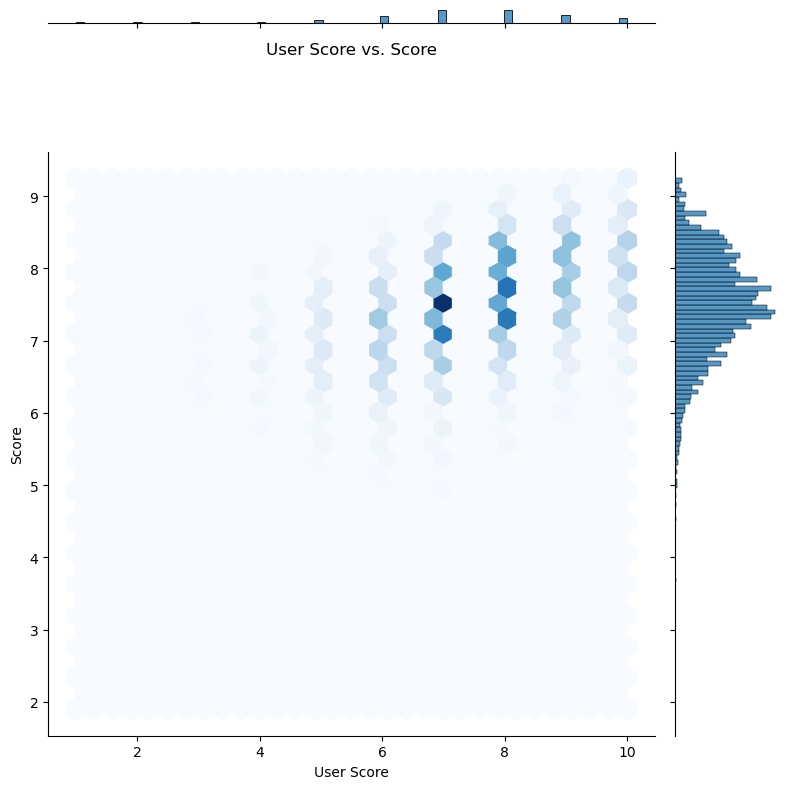

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

small_data = df.limit(40000)  # only take 1000 rows
# Filter out rows where "my_score" is zero and "popularity" is zero
filtered_data = small_data.filter((small_data["my_score"] != 0) & (small_data["score"] != 0))
filtered_data = filtered_data.withColumn("score", filtered_data["score"].cast("float"))

# Convert the Spark DataFrame to a pandas DataFrame for visualization
data_pd = filtered_data.toPandas()

# Create the jointplot for User's Score vs. Overall Anime Score
sns.jointplot(x='my_score', y='score', data=data_pd, kind='hex', cmap='Blues', height=8, gridsize=30)
plt.title('User Score vs. Score', loc='center', pad=70)
plt.xlabel('User Score')
plt.ylabel('Score')
plt.tight_layout()

# Save the plot to a file
plt.savefig('user_score_vs_score.png')

# Display the plot
plt.show()

## Number of Users who Scored vs. Overall Anime Score

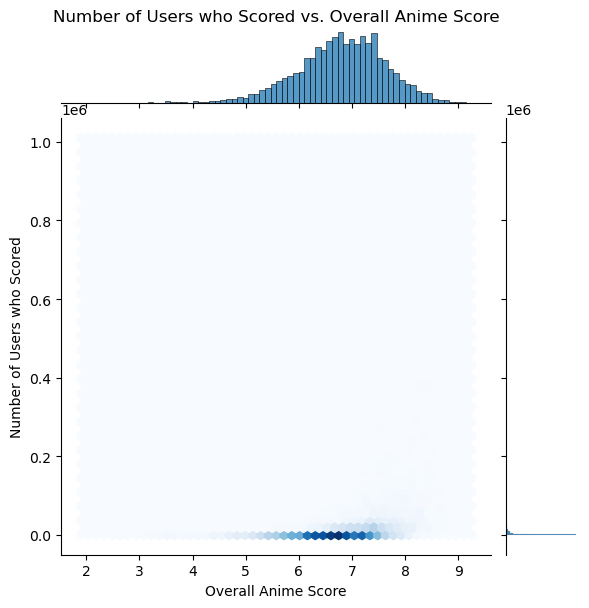

In [13]:
# 1. Convert the necessary columns of the Spark DataFrame to a Pandas DataFrame for visualization.
filtered_data = df.withColumn("score", df["score"].cast("float"))
plot_data_pd =filtered_data.select("score", "scored_by").distinct().toPandas()

# 2. Create the seaborn joint plot.
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(x='score', y='scored_by', data=plot_data_pd, kind='hex', cmap='Blues')
plt.title('Number of Users who Scored vs. Overall Anime Score', loc='center', pad=70)
plt.xlabel('Overall Anime Score')
plt.ylabel('Number of Users who Scored')
plt.show()
